In [1]:
using HTTP
using DataFrames
using CSV

# get public data
# Presidenza del Consiglio dei Ministri - Dipartimento della Protezione Civile
# https://github.com/pcm-dpc/COVID-19
res = HTTP.get("https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-regioni/dpc-covid19-ita-regioni.csv")
df = CSV.read(res.body);

In [2]:
# filter data
lombardia = filter(row -> row[:codice_regione] == 3, df)
filtered = lombardia[:, [:totale_casi, :dimessi_guariti, :deceduti]];

## The SIR model without vital dynamics
The dynamics of an epidemic, for example the flu, are often much faster than the dynamics of birth and death, therefore, birth and death are often omitted in simple compartmental models. The SIR system without so-called vital dynamics (birth and death, sometimes called demography) described above can be expressed by the following set of ordinary differential equations:

$$\frac{dS}{dt} = -\frac{\beta IS}{N}$$

$$\frac{dI}{dt} = \frac{\beta IS}{N} - \gamma I$$

$$\frac{dR}{dt} = \gamma I$$

where:

$$\frac{dS}{dt} + \frac{dI}{dt} + \frac{dR}{dt} = 0$$

$$S(t) + I(t) + R(t) = N$$

In [4]:
# https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology
# polulation
N = 10e6
# infected
I = transpose(filtered[!, 1])
# i = 3.0 .* i
# death
d = transpose(filtered[!, 2])
# recovered
g = transpose(filtered[!, 3])
# recovered+death
R = d .+ g
# susceptible population
S = N .- I

data2 = vcat(S, I, R)
tinterval = 1:1:size(S)[2]
t = collect(tinterval);

In [47]:
using DifferentialEquations, ParameterizedFunctions, LinearAlgebra

p = [0.336816, 0.0679648]
N = 10e6
C = 172
# https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology
f = function (du, u, p, t) # Define f as an in-place update into du
    N = u[1]+u[2]+u[3]
    b, g = p
    du[1] = -b*u[1]*u[2]/N
    du[2] = b*u[1]*u[2]/N - g*u[2]
    du[3] = g*u[2]
end

#9 (generic function with 1 method)

In [48]:
u0 = [N-C; C; 0.0]; tspan = (0.0, 50.0)
prob = ODEProblem(f, u0, tspan, p);

In [49]:
using ParameterizedFunctions, OrdinaryDiffEq, DiffEqParamEstim, LinearAlgebra
using BlackBoxOptim, NLopt, Plots, RecursiveArrayTools #, QuadDIRECT

loc_bounds = Tuple{Float64, Float64}[(0, 5), (0, 5),]
glo_bounds = Tuple{Float64, Float64}[(0, 10), (0, 10),]
loc_init = [1,0.5]
glo_init = [5,5]

obj = build_loss_objective(prob,Tsit5(),L2Loss(t,data2),tstops=t)
res1 = bboptimize(obj;SearchRange = glo_bounds, MaxSteps = 7e3)

Starting optimization with optimizer DiffEvoOpt{FitPopulation{Float64},RadiusLimitedSelector,BlackBoxOptim.AdaptiveDiffEvoRandBin{3},RandomBound{ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps

Optimization stopped after 7001 steps and 0.19 seconds
Termination reason: Max number of steps (7000) reached
Steps per second = 36274.60
Function evals per second = 36937.81
Improvements/step = 0.21714
Total function evaluations = 7129


Best candidate found: [0.252338, 0.0205273]

Fitness: 4596941664.287469864



BlackBoxOptim.OptimizationResults("adaptive_de_rand_1_bin_radiuslimited", "Max number of steps (7000) reached", 7001, 1.584833894518e9, 0.19300007820129395, DictChain{Symbol,Any}[DictChain{Symbol,Any}[Dict{Symbol,Any}(:RngSeed => 622666,:SearchRange => Tuple{Float64,Float64}[(0.0, 10.0), (0.0, 10.0)],:MaxSteps => 7000),Dict{Symbol,Any}()],Dict{Symbol,Any}(:FitnessScheme => ScalarFitnessScheme{true}(),:NumDimensions => :NotSpecified,:PopulationSize => 50,:MaxTime => 0.0,:SearchRange => (-1.0, 1.0),:Method => :adaptive_de_rand_1_bin_radiuslimited,:MaxNumStepsWithoutFuncEvals => 100,:RngSeed => 1234,:MaxFuncEvals => 0,:SaveTrace => false…)], 7129, ScalarFitnessScheme{true}(), BlackBoxOptim.TopListArchiveOutput{Float64,Array{Float64,1}}(4.59694166428747e9, [0.25233754841894135, 0.020527293865457437]), BlackBoxOptim.PopulationOptimizerOutput{FitPopulation{Float64}}(FitPopulation{Float64}([0.2523369773484451 0.2523376472441256 … 0.2523377644898396 0.2523376689950775; 0.02052669671365039 0.02

In [54]:
p = [0.252338, 0.0205273]
u0 = [N-C; C; 0.0]; tspan = (0.0, 100.0)
prob = ODEProblem(f, u0, tspan, p);
# Solve the problem
sol = solve(prob);

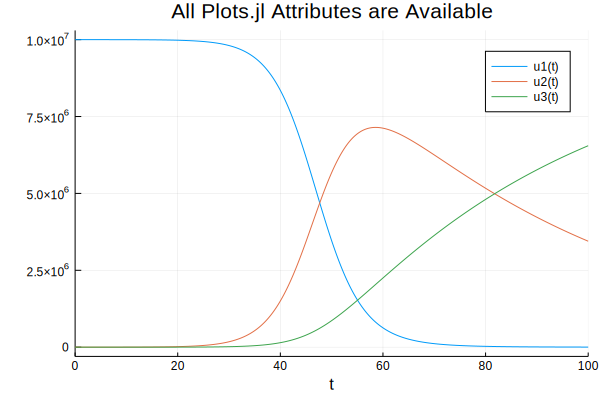

In [55]:
using Plots; gr() # Using the Plotly Backend
plot(sol,title="All Plots.jl Attributes are Available")

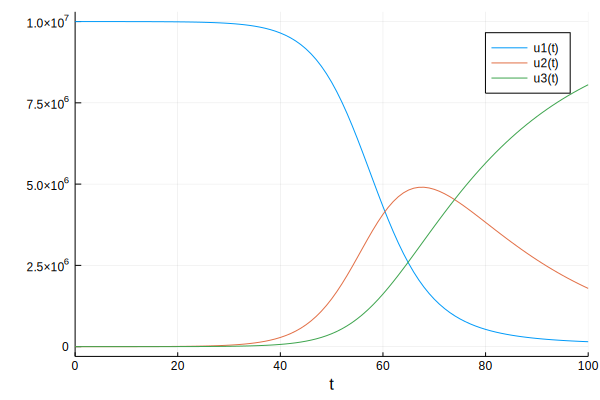

In [39]:
dt = 1.0 # one day
tf = 100.0
tinterval = 0:dt:tf
t  = collect(tinterval)

data_sol = solve(prob,Tsit5(),saveat=t,reltol=1e-9,abstol=1e-9)
data = convert(Array, data_sol)
p2 = plot(data_sol)

In [41]:
N.-data[1, 20:35]

16-element Array{Float64,1}:
   7284.027606705204
   8782.12889236398 
  10586.255937043577
  12758.758065983653
  15374.613587506115
  18523.95450295694 
  22315.080920545384
  26878.05338125862 
  32368.963997161016
  38975.00039566122 
  46920.4289632272  
  56473.63423973322 
  67955.35748014227 
  81748.27581153437 
  98308.0489680022  
 118175.92640557885 

In [81]:
using ParameterizedFunctions, OrdinaryDiffEq, DiffEqParamEstim, LinearAlgebra
using BlackBoxOptim, NLopt, Plots, RecursiveArrayTools #, QuadDIRECT

f = function (du, u, p, t) # Define f as an in-place update into du
    N = u[1]+u[2]+u[3]
    b, g = p
    du[1] = -b*u[1]*u[2]/N
    du[2] = b*u[1]*u[2]/N - g*u[2]
    du[3] = g*u[2]
end

u0 = [N-C; C; 0.0];  tspan = (0.0, 30)
p = [.1, .06]
prob = ODEProblem(f, u0, tspan, p)

ODEProblem with uType Array{Float64,1} and tType Float64. In-place: true
timespan: (0.0, 30.0)
u0: [3.99998e6, 20.0, 0.0]

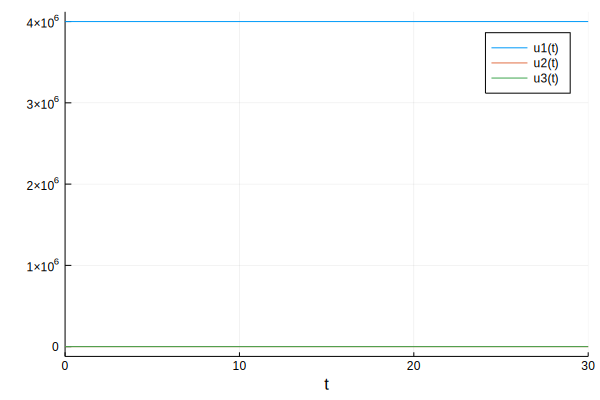

In [85]:
dt = 30.0/10
tf = 30.0
tinterval = 0:dt:tf
t  = collect(tinterval)

data_sol = solve(prob,Tsit5(),saveat=t,reltol=1e-9,abstol=1e-9)
data = convert(Array, data_sol)
p2 = plot(data_sol)

In [86]:
loc_bounds = Tuple{Float64, Float64}[(0, 5), (0, 5),]
glo_bounds = Tuple{Float64, Float64}[(0, 10), (0, 10),]
loc_init = [1,0.5]
glo_init = [5,5]

obj = build_loss_objective(prob,Tsit5(),L2Loss(t,data),tstops=t)
res1 = bboptimize(obj;SearchRange = glo_bounds, MaxSteps = 7e3)

Starting optimization with optimizer DiffEvoOpt{FitPopulation{Float64},RadiusLimitedSelector,BlackBoxOptim.AdaptiveDiffEvoRandBin{3},RandomBound{ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps

Optimization stopped after 7001 steps and 0.13 seconds
Termination reason: Max number of steps (7000) reached
Steps per second = 55563.52
Function evals per second = 56293.68
Improvements/step = 0.23171
Total function evaluations = 7093


Best candidate found: [0.1, 0.06]

Fitness: 0.000000000



BlackBoxOptim.OptimizationResults("adaptive_de_rand_1_bin_radiuslimited", "Max number of steps (7000) reached", 7001, 1.584817724602e9, 0.12599992752075195, DictChain{Symbol,Any}[DictChain{Symbol,Any}[Dict{Symbol,Any}(:RngSeed => 148888,:SearchRange => Tuple{Float64,Float64}[(0.0, 10.0), (0.0, 10.0)],:MaxSteps => 7000),Dict{Symbol,Any}()],Dict{Symbol,Any}(:FitnessScheme => ScalarFitnessScheme{true}(),:NumDimensions => :NotSpecified,:PopulationSize => 50,:MaxTime => 0.0,:SearchRange => (-1.0, 1.0),:Method => :adaptive_de_rand_1_bin_radiuslimited,:MaxNumStepsWithoutFuncEvals => 100,:RngSeed => 1234,:MaxFuncEvals => 0,:SaveTrace => false…)], 7093, ScalarFitnessScheme{true}(), BlackBoxOptim.TopListArchiveOutput{Float64,Array{Float64,1}}(1.4694906652546934e-11, [0.09999999854515598, 0.059999997875776284]), BlackBoxOptim.PopulationOptimizerOutput{FitPopulation{Float64}}(FitPopulation{Float64}([0.09999999143452297 0.10000007207185765 … 0.10000011128217395 0.10000012604849998; 0.05999998883283

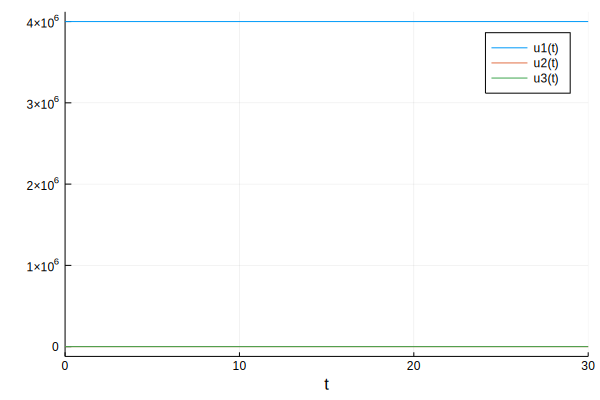

In [72]:
dt = 30.0/3000
tf = 30.0
tinterval = 0:dt:tf
t  = collect(tinterval)

data_sol = solve(prob,Tsit5(),saveat=t,reltol=1e-9,abstol=1e-9)
data = convert(Array, data_sol)
p2 = plot(data_sol)

In [73]:
loc_bounds = Tuple{Float64, Float64}[(0, 5), (0, 5),]
glo_bounds = Tuple{Float64, Float64}[(0, 10), (0, 10),]
loc_init = [1,0.5]
glo_init = [5,5]

obj = build_loss_objective(prob,Tsit5(),L2Loss(t,data),tstops=t)
res1 = bboptimize(obj;SearchRange = glo_bounds, MaxSteps = 7e3)

Starting optimization with optimizer DiffEvoOpt{FitPopulation{Float64},RadiusLimitedSelector,BlackBoxOptim.AdaptiveDiffEvoRandBin{3},RandomBound{ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps
0.50 secs, 306 evals, 223 steps, improv/step: 0.381 (last = 0.3812), fitness=7024354.146212650
1.00 secs, 610 evals, 507 steps, improv/step: 0.286 (last = 0.2113), fitness=7024354.146212650
1.50 secs, 921 evals, 813 steps, improv/step: 0.271 (last = 0.2451), fitness=7024354.146212650
2.01 secs, 1228 evals, 1121 steps, improv/step: 0.256 (last = 0.2175), fitness=5998009.165664076
2.51 secs, 1547 evals, 1440 steps, improv/step: 0.258 (last = 0.2633), fitness=1801580.797768015
3.01 secs, 1861 evals, 1754 steps, improv/step: 0.247 (last = 0.2006), fitness=663743.553672204
3.51 secs, 2179 evals, 2072 steps, improv/step: 0.250 (last = 0.2610), fitness=25412.656532885
4.01 secs, 2488 evals, 2381 steps, improv/step: 0.251 (last = 0.2589), fitness=15755.245030277
4.51 secs, 2800 evals, 2693 steps,

BlackBoxOptim.OptimizationResults("adaptive_de_rand_1_bin_radiuslimited", "Max number of steps (7000) reached", 7001, 1.584815835775e9, 11.373999834060669, DictChain{Symbol,Any}[DictChain{Symbol,Any}[Dict{Symbol,Any}(:RngSeed => 250349,:SearchRange => Tuple{Float64,Float64}[(0.0, 10.0), (0.0, 10.0)],:MaxSteps => 7000),Dict{Symbol,Any}()],Dict{Symbol,Any}(:FitnessScheme => ScalarFitnessScheme{true}(),:NumDimensions => :NotSpecified,:PopulationSize => 50,:MaxTime => 0.0,:SearchRange => (-1.0, 1.0),:Method => :adaptive_de_rand_1_bin_radiuslimited,:MaxNumStepsWithoutFuncEvals => 100,:RngSeed => 1234,:MaxFuncEvals => 0,:SaveTrace => false…)], 7104, ScalarFitnessScheme{true}(), BlackBoxOptim.TopListArchiveOutput{Float64,Array{Float64,1}}(9.52376512575018e-13, [0.10000000001741918, 0.06000000003167989]), BlackBoxOptim.PopulationOptimizerOutput{FitPopulation{Float64}}(FitPopulation{Float64}([0.10000000166228173 0.1000000007108997 … 0.10000000001741918 0.10000000045665426; 0.06000000306619755 0

In [22]:
loc_bounds = Tuple{Float64, Float64}[(0, 1), (0, 1),]
glo_bounds = Tuple{Float64, Float64}[(0, 10), (0, 10),]
loc_init = [1,1]
glo_init = [5,5]

obj = build_loss_objective(prob,Tsit5(),L2Loss(t,data2),tstops=t)
res1 = bboptimize(obj;SearchRange = glo_bounds, MaxSteps = 1e5)

Starting optimization with optimizer DiffEvoOpt{FitPopulation{Float64},RadiusLimitedSelector,BlackBoxOptim.AdaptiveDiffEvoRandBin{3},RandomBound{ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps
0.51 secs, 15627 evals, 15712 steps, improv/step: 0.119 (last = 0.1192), fitness=294533216.648508906

Optimization stopped after 17027 steps and 0.52 seconds
Termination reason: Too many steps (101) without any function evaluations (probably search has converged)
Steps per second = 32556.41
Function evals per second = 30919.69
Improvements/step = 0.01930
Total function evaluations = 16171


Best candidate found: [0.230605, 0.0443577]

Fitness: 294533216.648508906



BlackBoxOptim.OptimizationResults("adaptive_de_rand_1_bin_radiuslimited", "Too many steps (101) without any function evaluations (probably search has converged)", 17027, 1.58483176901e9, 0.5230000019073486, DictChain{Symbol,Any}[DictChain{Symbol,Any}[Dict{Symbol,Any}(:RngSeed => 925307,:SearchRange => Tuple{Float64,Float64}[(0.0, 10.0), (0.0, 10.0)],:MaxSteps => 100000),Dict{Symbol,Any}()],Dict{Symbol,Any}(:FitnessScheme => ScalarFitnessScheme{true}(),:NumDimensions => :NotSpecified,:PopulationSize => 50,:MaxTime => 0.0,:SearchRange => (-1.0, 1.0),:Method => :adaptive_de_rand_1_bin_radiuslimited,:MaxNumStepsWithoutFuncEvals => 100,:RngSeed => 1234,:MaxFuncEvals => 0,:SaveTrace => false…)], 16171, ScalarFitnessScheme{true}(), BlackBoxOptim.TopListArchiveOutput{Float64,Array{Float64,1}}(2.945332166485089e8, [0.23060508020223047, 0.04435770861412677]), BlackBoxOptim.PopulationOptimizerOutput{FitPopulation{Float64}}(FitPopulation{Float64}([0.23060508020223047 0.23060508020223047 … 0.230605